In [1]:
## We need to create dataset first.
## Let's create dataset for both test data and train data

In [2]:
## For this project I decided to only have melspectrogram data for Stage I.

In [3]:
## To build test data

In [4]:
# ##ALL THE IMPORTS
import pandas as pd
import librosa
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [5]:
## The output.csv file contain the path to all the audio files which we will use to iterate
df = pd.read_csv("output.csv")

In [6]:
## The different genre of the class we have

# CLASS_ORDER = ['pop','metal','disco','blues','reggae','classical','rock','hiphop','country','jazz']

In [7]:
# folder = CLASS_ORDER
# paths_per_folder = [[] for _ in folder]

# for f, grp in df.groupby("folder"):
#     if f in folder:
#         i = folder.index(f)
#         paths_per_folder[i] = grp["full_path"].dropna().tolist()

# ## Took all the paths from the output.csv and put them in a list

In [8]:
# def load_list_of_paths(paths, sr=22050, mono=True, seconds=30.0, trim_db=40):
#     """Return [(y, sr), ...] with each y pad/truncated to the same length."""
#     target = int(sr * seconds)
#     out = []
#     for p in paths:
#         y, sr_loaded = librosa.load(p, sr=sr, mono=mono)
#         if trim_db is not None:
#             y, _ = librosa.effects.trim(y, top_db=trim_db)
#             # pad / truncate to fixed length
#         if len(y) < target:
#             y = np.pad(y, (0, target - len(y)))
#         else:
#             y = y[:target]
#             out.append((y, sr))      # <-- tuple per file
#     return out

# pop, metal, disco, blues, reggae, classical, rock, hiphop, country, jazz = [
#     load_list_of_paths(paths, sr=22050, mono=True, seconds=30.0)
#     for paths in paths_per_folder
# ]  

In [9]:
# def compute_melspectogram_by_genre(signals_by_genre, **kwargs):
#     """
#     signals_by_genre: dict like {'pop': [(y, sr), (y, sr), ...], 'metal': [...], ...}
#     returns: dict like {'pop': [mfcc_array, ...], 'metal': [mfcc_array, ...], ...}
#     """
#     return {
#         genre: [librosa.feature.melspectrogram(
#             y=y,
#             sr=22050,        # fixed resample rate
#             n_fft=2048,      # freq resolution
#             hop_length=512,  # time resolution
#             win_length=2048, # keep = n_fft for consistency
#             window="hann",   # fixed window type
#             center=True,
#             pad_mode="constant",
#             power=2.0,
#             n_mels=128,      # fixed mel bands (height)
#             fmin=0.0,
#             fmax=8000.0,     # IMPORTANT: keep fixed across all songs
#             htk=False,
#             norm="slaney"
#             )
#                 for (y, sr_i) in pairs]
#         for genre, pairs in signals_by_genre.items()
#     }

In [10]:
# signals_by_genre = {
#     "pop": pop, "metal": metal, "disco": disco, "blues": blues, "reggae": reggae,
#     "classical": classical, "rock": rock, "hiphop": hiphop, "country": country, "jazz": jazz
# }
# melspectogram = compute_melspectogram_by_genre(signals_by_genre) ## Computer melspectogram for all the signals

In [11]:
# signal, sr = librosa.load("data/train/blues/blues.00000.au", sr= 22050, mono = True)

In [12]:
# melspectrogram = librosa.feature.melspectrogram(
#             y=signal,
#             sr=22050,        # fixed resample rate
#             n_fft=2048,      # freq resolution
#             hop_length=512,  # time resolution
#             win_length=2048, # keep = n_fft for consistency
#             window="hann",   # fixed window type
#             center=True,
#             pad_mode="constant",
#             power=2.0,
#             n_mels=128,      # fixed mel bands (height)
#             fmin=0.0,
#             fmax=8000.0,     # IMPORTANT: keep fixed across all songs
#             htk=False,
#             norm="slaney"
#             )

In [13]:
# melspectrogram.shape

In [14]:
# melspectrogram

In [15]:
GENRES = ['pop','metal','disco','blues','reggae',
          'classical','rock','hiphop','country','jazz']

genre_to_idx = {g:i for i,g in enumerate(GENRES)}

In [16]:
def load_fixed_audio(path, sr=22050, seconds=30, trim_db = 40):
    y, _ = librosa.load(path, sr=sr, mono=True)
    target = sr * seconds
    y, _ = librosa.effects.trim(y, top_db=trim_db)
    
    if len(y) < target:
        y = np.pad(y, (0, target-len(y)))
    else:
        y = y[:target]
    return y, sr

In [17]:
def get_logmel(y, sr):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_fft=2048,
        hop_length=512,
        win_length=2048,
        window="hann",
        center=True,
        pad_mode="constant",
        power=2.0,
        n_mels=128,
        fmin=0.0,
        fmax=8000.0,
        htk=False,
        norm="slaney"
    )
    logmel = librosa.power_to_db(mel, ref=np.max)
    return logmel  # (128, 1293)

In [18]:
X_list = []
y_list = []

for i, row in df.iterrows():
    path  = row["full_path"]
    genre = row["folder"]     
    
    # 1) audio
    y, sr = load_fixed_audio(path)

    # 2) spectrogram
    spec = get_logmel(y, sr)   # (128,1293)

    X_list.append(spec)
    y_list.append(genre_to_idx[genre])

In [19]:
print(len(X_list), len(y_list))
print(X_list[0].shape)

900 900
(128, 1292)


In [20]:
X = np.stack(X_list)   # (900, 128, 1293)
y = np.array(y_list)   # (900,)
print(X.shape, y.shape)

(900, 128, 1292) (900,)


In [21]:
X_norm = (X - X.mean(axis=(1,2), keepdims=True)) / (X.std(axis=(1,2), keepdims=True) + 1e-8)
print(X_norm.shape)   # (900, 128, 1292)

# then add channel
X_norm = X_norm[:, np.newaxis, :, :]
print(X_norm.shape)   # (900, 1, 128, 1292)

(900, 128, 1292)
(900, 1, 128, 1292)


In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_norm, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("y_train:", y_train.shape)
print("y_val  :", y_val.shape)

# lets normalize the data


X_train: (720, 1, 128, 1292)
X_val  : (180, 1, 128, 1292)
y_train: (720,)
y_val  : (180,)


In [ ]:

# here we will define a simple convolutional neural network using PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# lets do a VGG style CNN
class SimpleVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleVGG, self).__init__()
        
        self.num_classes = num_classes
        self.layer1 = self.block(1, 64, 2)  
        self.layer2 = self.block(64, 128, 2)
        self.layer3 = self.block(128, 256, 3)
        self.layer4 = self.block(256, 512, 3)
        self.layer5 = self.block(512, 512, 3)

        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))  
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 1292)  
            feat = self.forward_helper(dummy)
            flat_dim = feat.view(1, -1).size(1)


        # initialize fully the classifier
        
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes),
            
        )

    

    def block(self, in_channels, out_channels, num_convs):
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)
    
    
    def forward_helper(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        

        return x
    
    def forward(self, x):
        x = self.forward_helper(x)
        x = torch.flatten(x, 1)  
        x = self.classifier(x)

        return x
       
model = SimpleVGG(num_classes=10).to(device)
print(model)





SimpleVGG(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Max

In [ ]:
#lets train the model using  test split created before

def train_model(model, X_train, y_train, X_val, y_val, num_epochs=10, batch_size=32, learning_rate=0.001):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

    # Create Datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    # Create DataLoader for batching
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
 
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=.01)


    # ensure model is on the correct device
    model.to(device)

    

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            # load inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)


            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)


        epoch_loss = running_loss / len(train_loader.dataset)

        # lists to store validation loss and accuracy
        loss_list = []
        val_acc_list = []
        val_loss_list = []
        # Validation
        model.eval()
        total = 0
        val_loss = 0.0
        val_accuracy = 0.0
        accuracy = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                val_outputs = model(inputs)
                loss = criterion(val_outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, val_preds = torch.max(val_outputs, 1)
                accuracy += ((val_preds == labels).sum().item())
                total += labels.size(0)
                
        val_loss = val_loss / total
        val_accuracy = accuracy / total
        loss_list.append(epoch_loss)
        val_acc_list.append(val_accuracy)
        val_loss_list.append(val_loss)


        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    return loss_list, val_loss_list, val_acc_list

# low accuracy - wont use
# train_model(model, X_train, y_train, X_val, y_val, num_epochs=10, batch_size=32, learning_rate=0.0001) 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, use_1x1=False, stride=1,downsample=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels,
                                       out_channels, 
                                       kernel_size = 3, 
                                       stride = stride, 
                                       padding = 1),
                           )
        self.bn1 = nn.BatchNorm2d(out_channels)
    
        self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, 
                                    out_channels,
                                    kernel_size = 3, 
                                    stride = 1, 
                                    padding = 1),
                           )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels


    def forward(self, X):
        residual = X.clone()
        out = self.relu(self.bn1(self.conv1(X)))
        out = self.bn2(self.conv2(out))
        
        
        if self.downsample:
            residual = self.downsample(residual)
        
        out += residual
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self,block,layers, num_classes=10):
            super(ResNet, self).__init__()
            self.planes = 64
            self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.batch_norm1 = nn.BatchNorm2d(64)
            self.relu = nn.ReLU()


            self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
            # self.max_pool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        
            # self.max_pool = nn.MaxPool2d (kernel_size=2, stride=2)


            
            self.layer1 = self.new_layer(block, layers[0], planes=64)
            self.layer2 = self.new_layer(block, layers[1], planes=128, stride=2)
            self.layer3 = self.new_layer(block, layers[2], planes=256, stride=2)
            self.layer4 = self.new_layer(block, layers[3], planes=512, stride=2)
            
            self.avgpool = nn.AdaptiveAvgPool2d((1,1))
            self.fc = nn.Linear(512*ResidualBlock.expansion, num_classes)

    def new_layer(self,block,blocks,planes,stride=1):
            downsample = None
            if(stride != 1) or (self.planes != planes):
                downsample = nn.Sequential(
                                    nn.Conv2d(self.planes,planes,kernel_size=1,stride=stride),
                                    nn.BatchNorm2d(planes*block.expansion))
            layers = []
            layers.append(block(self.planes,planes,downsample=downsample,stride=stride))
            self.planes = planes*block.expansion
            for i in range(1,blocks):
                layers.append(block(self.planes,planes))

            return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
model2 = ResNet(ResidualBlock,[2,2,2,2], num_classes=10).to(device)
print(model2)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [28]:
train_model(model2, X_train, y_train, X_val, y_val, num_epochs=10, batch_size=32, learning_rate=0.000008)

Epoch 1/10, Loss: 2.2663, Val Loss: 2.5231, Val Acc: 0.1000
Epoch 2/10, Loss: 2.0137, Val Loss: 2.0563, Val Acc: 0.2778
Epoch 3/10, Loss: 1.7738, Val Loss: 1.7946, Val Acc: 0.3556
Epoch 4/10, Loss: 1.4924, Val Loss: 1.5257, Val Acc: 0.5222
Epoch 5/10, Loss: 1.2987, Val Loss: 1.3566, Val Acc: 0.5722
Epoch 6/10, Loss: 1.1249, Val Loss: 1.2199, Val Acc: 0.6278
Epoch 7/10, Loss: 0.9792, Val Loss: 1.1412, Val Acc: 0.6556
Epoch 8/10, Loss: 0.8729, Val Loss: 1.0355, Val Acc: 0.6889
Epoch 9/10, Loss: 0.7669, Val Loss: 1.0152, Val Acc: 0.6889
Epoch 10/10, Loss: 0.6633, Val Loss: 0.9573, Val Acc: 0.7000


([0.6633192234569125], [0.9572918282614814], [0.7])

In [29]:
# lets find f1 score on validation set
from sklearn.metrics import f1_score
y_val_preds = []
model2.eval()
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.long).to(device))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model2(inputs)
        _, preds = torch.max(outputs, 1)
        y_val_preds.extend(preds.cpu().numpy())
f1 = f1_score(y_val, y_val_preds, average='weighted')
print(f"F1 Score on validation set: {f1:.4f}")

F1 Score on validation set: 0.6895


In [30]:
# load data/test/


import librosa
import numpy as np

def get_logmel(y, sr):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_fft=2048,
        hop_length=512,
        win_length=2048,
        window="hann",
        center=True,
        pad_mode="constant",
        power=2.0,
        n_mels=128,
        fmin=0.0,
        fmax=8000.0,
        htk=False,
        norm="slaney"
    )
    logmel = librosa.power_to_db(mel, ref=np.max)
    return logmel  # (128, 1293)

def load_fixed_audio(path, sr=22050, seconds=30, trim_db = 40):
    y, _ = librosa.load(path, sr=sr, mono=True)
    target = sr * seconds
    y, _ = librosa.effects.trim(y, top_db=trim_db)
    
    if len(y) < target:
        y = np.pad(y, (0, target-len(y)))
    else:
        y = y[:target]
    return y, sr



GENRES = ['pop','metal','disco','blues','reggae',
          'classical','rock','hiphop','country','jazz']

genre_to_idx = {g:i for i,g in enumerate(GENRES)}


# lets load all audios and put them into arrays
# read the names of test data from: 'data/test/list_test.txt'

def load_data(GENRES=GENRES):
    X = []
    test_audios = []
    with open('data/test/list_test.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            filepath = line.strip()
            test_audios.append(filepath)

            filepath = 'data/test/' + filepath
        
                
            audio, sr = load_fixed_audio(filepath)
            logmel = get_logmel(audio, sr)
            X.append(logmel)
 
    X = np.array(X)  # shape (num_samples, 128, 1293)
   
    return X,test_audios

X, test_audios = load_data()
print(f'X array shape: {X.shape}')
print(f'Number of test audios: {len(test_audios)}')

X array shape: (100, 128, 1292)
Number of test audios: 100


In [31]:
# must get tensors
model2.eval()
predictions = []



with torch.no_grad():
    for i in range(X.shape[0]):
        spec = X[i]                     

       
        mean = spec.mean()
        std  = spec.std() + 1e-8
        spec = (spec - mean) / std         

        spec = torch.tensor(spec, dtype=torch.float32)

       
        spec = spec.unsqueeze(0).unsqueeze(0)  

 
        spec = spec.to(device)

        output = model2(spec)                 
        _, pred = torch.max(output, dim=1)
        predictions.append(pred.item())


idx_to_genre = {i:g for g,i in genre_to_idx.items()}
labels = [idx_to_genre[p] for p in predictions]

# save to csv
import pandas as pd
cnn_pred = "data/test/predictions.csv"
df = pd.DataFrame({
    "id": test_audios,   
    "class": labels     
})
df.to_csv(cnn_pred, index=False)

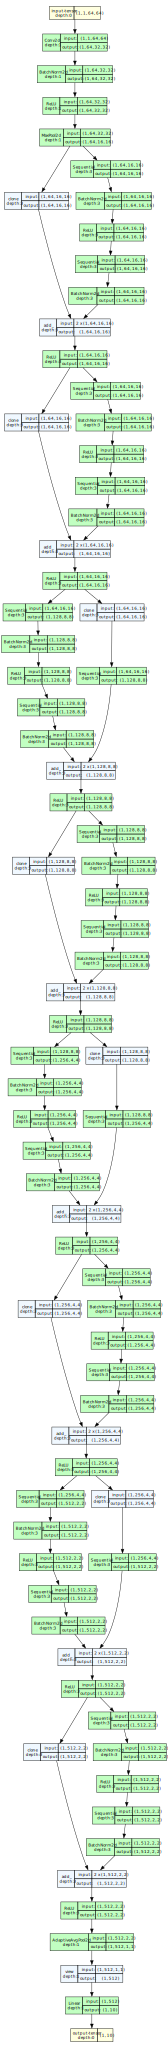

In [ ]:
# visualize network architecture

from torchview import draw_graph
model_graph = draw_graph(model2, input_size=(1, 1, 64, 64), device='meta')
model_graph.visual_graph